<a href="https://colab.research.google.com/github/MarcelloCeresini/ChessBreaker/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
username = 'MarcelloCeresini'
repository = 'ChessBreaker'

In [3]:
# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !nvidia-smi             # Check which GPU has been chosen for us
    !rm -rf logs
    #from google.colab import drive
    #drive.mount('/content/drive')
    #%cd /content/drive/MyDrive/GitHub/
    !git clone https://github.com/{username}/{repository}.git
    %cd {repository}
    %ls
    !pip3 install anytree
except:
    IN_COLAB = False

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Cloning into 'ChessBreaker'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 223 (delta 18), reused 45 (delta 13), pack-reused 172
Receiving objects: 100% (223/223), 1.11 MiB | 24.11 MiB/s, done.
Resolving deltas: 100% (117/117), done.
/content/ChessBreaker
data/                  main.ipynb       notes.txt   requirements.txt
data_processing.ipynb  mini_resnet.png  old_stuff/  results/
imitation_learning.py  model.py         README.md   utils.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 487 kB/s 


In [4]:
import numpy as np
import tensorflow as tf
import chess
from anytree import Node
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from queue import Queue
from collections import Counter

from numpy.random import default_rng
rng = default_rng()

import utils
from utils import plane_dict, Config, x_y_from_position
from model import ResNet

conf = Config()
board = chess.Board()

# legal_moves = board.legal_moves
# for move in legal_moves:
#     print(move.uci())  
# print(legal_moves)


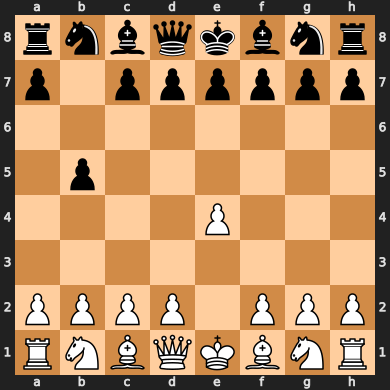

In [ ]:
board = chess.Board()
board.set_fen('rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBNR w KQkq')
board

In [ ]:
def special_input_planes(board):                                    # not repeated planes
    
    special_planes = np.zeros([*conf.BOARD_SHAPE, conf.SPECIAL_PLANES], conf.PLANES_DTYPE_NP)
    special_planes[:,:,0] = board.turn                                 
    special_planes[:,:,1] = board.fullmove_number-1                    
    special_planes[:,:,2] = board.has_kingside_castling_rights(True)   
    special_planes[:,:,3] = board.has_queenside_castling_rights(True)  
    special_planes[:,:,4] = board.has_kingside_castling_rights(False)  
    special_planes[:,:,5] = board.has_queenside_castling_rights(False) 
    special_planes[:,:,6] = board.halfmove_clock                       
    
    # special_planes = np.stack([
    #     np.full([*conf.BOARD_SHAPE], int(board.turn                                 ), conf.PLANES_DTYPE_NP),   # whose turn it is
    #     np.full([*conf.BOARD_SHAPE], int(board.fullmove_number-1                    ), conf.PLANES_DTYPE_NP),   # don't know why but it starts from 1 on move 1, just reduce it by one and now it's right (MAX 255, using uint8!!)
    #     np.full([*conf.BOARD_SHAPE], int(board.has_kingside_castling_rights(True)   ), conf.PLANES_DTYPE_NP),   # True for White
    #     np.full([*conf.BOARD_SHAPE], int(board.has_queenside_castling_rights(True)  ), conf.PLANES_DTYPE_NP),
    #     np.full([*conf.BOARD_SHAPE], int(board.has_kingside_castling_rights(False)  ), conf.PLANES_DTYPE_NP),   # False for Black
    #     np.full([*conf.BOARD_SHAPE], int(board.has_queenside_castling_rights(False) ), conf.PLANES_DTYPE_NP),
    #     np.full([*conf.BOARD_SHAPE], int(board.halfmove_clock                       ), conf.PLANES_DTYPE_NP)    # number of moves from last capture / pawn move --> reaching 50 means draw
    # ])

    return special_planes                                            # transpose to have plane number last --> in order to concat them


# def update_planes(current, board, board_history):

#     if current == None: # root, initialize to zero
#         current = tf.zeros([*conf.BOARD_SHAPE, conf.TOTAL_PLANES], dtype=conf.PLANES_DTYPE)
    
#     planes = [] # since we cannot "change" a tensor after creating it, we create them one by one in a list and then stack them

#     for color in range(2):                                                                                                  # for each color
#         for piece_type in range(1, conf.N_PIECE_TYPES+1):                                                                   # for each piece type
#             indices = []                                                                                                    # --> we save the position on the board in a list
#             for position in list(board.pieces(piece_type, color)):                                                          # for each piece of that type
#                 indices.append(x_y_from_position(position))                                                                 # the function transforms a number (1-64) into a tuple (1-8, 1-8)
#             if len(indices) == 0:
#                 tensor = uniform_tensor(tf.constant(0, dtype=conf.PLANES_DTYPE))
#             else:
#                 values = np.array([1]*len(indices), dtype=conf.PLANES_DTYPE_NP) # simply "1" in a list with unit8 dtype
#                 tensor = tf.sparse.to_dense(tf.SparseTensor(dense_shape=[*conf.BOARD_SHAPE], indices=indices, values=values))   ### created as sparse because it's easier, needed as dense afterwards
#             planes.append(tensor)
#         planes.append(uniform_tensor(tf.constant(board_history.count(board_history[-1]), dtype=conf.PLANES_DTYPE)))         # adding a "repetition plane" for each color (simply count how many times the current (last) position has been encountered)

#     # 1 stack
#     current_planes = tf.transpose(tf.stack(planes), [1,2,0])    
#     print(tf.shape(current_planes))                                                            # transpose them to have the planes as last dimension
#     # 7 stacks (total 8 repetitions)
#     old_planes = tf.slice(current, begin=[0,0,0], size=[*conf.BOARD_SHAPE, (conf.PAST_TIMESTEPS-1)*conf.REPEATED_PLANES])   # take the first 7 repetitions, slice them and paste them at the end of the new planes (last is discarded, as are special planes)
    
#     return tf.concat([current_planes, old_planes, special_input_planes(board)], axis=-1)    # also concat the special planes

def update_planes(old, board, board_history):

    if type(old) != np.ndarray: # root, initialize to zero
        old = np.zeros([*conf.BOARD_SHAPE, conf.TOTAL_PLANES], dtype=conf.PLANES_DTYPE_NP)
    
    total_planes = np.zeros([*conf.BOARD_SHAPE, conf.TOTAL_PLANES], dtype=conf.PLANES_DTYPE_NP) # since we cannot "change" a tensor after creating it, we create them one by one in a list and then stack them
    plane = -1
    
    repetition_counter = board_history.count(board_history[-1])
    for color in range(2):                                                                                                  # for each color
        for piece_type in range(1, conf.N_PIECE_TYPES+1):                                                                   # for each piece type
            plane += 1
            indices = map(x_y_from_position, list(board.pieces(piece_type, color)))        # for each piece of that type                                                                                            # --> we save the position on the board in a list
            # the function transforms a number (1-64) into a tuple (1-8, 1-8)
            for idx in indices:
                total_planes[idx[0], idx[1], plane] = 1
        plane += 1
        total_planes[:, :, plane] = repetition_counter    # adding a "repetition plane" for each color (simply count how many times the current (last) position has been encountered)
   
    # 7 stacks (total 8 repetitions)
    total_planes[:, :, conf.REPEATED_PLANES:(conf.REPEATED_PLANES+conf.OLD_PLANES_TO_KEEP)] = old[:, :, :conf.OLD_PLANES_TO_KEEP]
    total_planes[:, :, conf.REPEATED_PLANES+conf.OLD_PLANES_TO_KEEP:] = special_input_planes(board)
    
    return total_planes


#0.04062032699584961
# 0.0007264614105224609


In [ ]:
class MyNode(Node): # subclassing Node from Anytree to add some methods

    def update_action_value(self, new_action_value):                                                        # used during backtracking to update action value if the simulation reached the end through that node
        self.action_value += (new_action_value-self.action_value)/(self.visit_count+1)                      # simply the mean value, but computed iteratively

    def calculate_upper_confidence_bound(self, num_total_iterations=1):                                     # Q + U --> U proportional to P/(1+N) --> parameter decides exploration vs. exploitation
        new_UCF = self.action_value + conf.expl_param(num_total_iterations)*self.prior/(1+self.visit_count)
        return new_UCF

    def calculate_move_probability(self, num_move=1):                                           # N^(1/tau) --> tau is a temperature parameter (exploration vs. exploitation)
        return self.visit_count**(1/conf.temp_param(num_move))


def MTCS(model, root_node, max_depth, num_restarts):
    '''
        The search descends until it finds a leaf to be evalued, then restarts until it gathers a batch of evaluations, then expands all the nodes in the batch
        If the maximum depth is reached, the algorithm then backpropagates the action value of the reached node back to the root of the tree
        Exploration incentivised by the decrease of action value / upper confidence bound with each visit to the node
        Exploitation incentivised by the two parameters temp_param and expl_param (respectively to choose almost surely the most probable move, and to focus more on the action value rather than the prior of the node)
    '''
    evaluation_counter = 0
    INIT_ROOT = root_node
    nodes_to_visit = Queue()
    # number of times to explore up until max_depth
    i = 0

    leaf_node_batch = []
    legal_moves_batch = []
    
    while i < num_restarts:
        if nodes_to_visit.empty():
            root_node = INIT_ROOT
            i+=1
        else:
            root_node = nodes_to_visit.get_nowait()
        # print(i, root_node.name, root_node.depth, root_node.visit_count)
        
        step_down = True
        control_counter = 0
        while step_down:
            control_counter+=1
            if control_counter > 2*max_depth: 
                print("stuck in loop, leaving")
                break # bigger margin, but if it is stuk in a loop for some reason, at least it leaves
            
            # assert root_node.depth >= 0 and root_node.depth <= max_depth, "depth is wrong"
            if root_node.is_leaf and not root_node.is_finish_position:                                                                           # if it's leaf --> need to pass the position (planes) through the model, to get priors (action_values) and outcome (state_value)
                step_down = False

                if len(root_node.siblings) > 0:         # this part is to try and avoid batching the same node twice (so we evaluate a random sibling instead)
                    leaf_node_list = [node.board_history for node in leaf_node_batch]
                    if root_node.board_history in leaf_node_list:
                        siblings_list = list(root_node.siblings)
                        random_sibling = np.random.choice(siblings_list)
                        while random_sibling.board_history in leaf_node_list and len(siblings_list)>1:
                            siblings_list.remove(random_sibling) #do it with np.random in a range, and POP instead of remove
                            random_sibling = np.random.choice(siblings_list)
                        
                        root_node = random_sibling
                        
                # important! save legal moves AFTER choosing root_node
                legal_moves = list(root_node.board.legal_moves)

                if len(legal_moves) == 0:
                    step_down = False
                    final_outcome = root_node.board.outcome(claim_draw=True)

                    if final_outcome != None:
                        root_node.is_finish_position = True
                        if final_outcome.winner == None:
                            root_node.action_value = 0
                        else:
                            root_node.action_value = int(final_outcome.winner)*2-1
                    else:
                        print("Something's wrong")
                else:
                    leaf_node_batch.append(root_node)
                    legal_moves_batch.append(legal_moves)
                
                root_node.visit_count += 1

                # print("to be evaluated", "d", root_node.depth, "vc", root_node.visit_count, "name", root_node.name)

                if len(leaf_node_batch) == conf.BATCH_DIM or root_node == INIT_ROOT:
                    # in order to avoid creating multiple times the children of the same node, we only keep unique values
                    if len(set(leaf_node_batch)) < conf.BATCH_DIM:
                        leaf_node_batch, legal_moves_batch = utils.reduce_repetitions(leaf_node_batch, legal_moves_batch)                    
                    
                    plane_list = [root_node.planes for root_node in leaf_node_batch]
                    # 0.0032072067260742188
                    # 7.05718994140625e-05
                    
                    planes = np.stack(plane_list)

                    full_moves_batch, outcome_batch = model(planes)
                    evaluation_counter+=1

                    full_moves_batch_np = full_moves_batch.numpy()
                    # print(np.shape(full_moves_batch_np[0]))
                    outcome_batch_np = outcome_batch.numpy()

                    if np.shape(full_moves_batch_np)[0] != 1:
                        full_moves_batch_np = np.moveaxis(full_moves_batch.numpy(), 0, 0)
                        outcome_batch_np = np.moveaxis(outcome_batch.numpy(), 0, 0)
                    
                    for root_node, full_moves, outcome, legal_moves in zip(leaf_node_batch, full_moves_batch_np, outcome_batch_np, legal_moves_batch):
                        nodes_to_visit.put_nowait(root_node)
                        
                        mask_idx = utils.mask_moves(legal_moves)
                        priors = [full_moves[idx[0], idx[1], idx[2]] for idx in mask_idx]                        # boolean mask returns a tensor of only the values that were masked (as a list let's say)
                        # 0.006434917449951172
                        # 1.3113021850585938e-05
                        root_node.action_value = outcome    
                        
                        if root_node == INIT_ROOT:  # increase exploration at the root, since if the network is not good it will not make good starting choices
                            dir_noise = rng.dirichlet([conf.ALPHA_DIRICHLET]*len(priors))
                            priors = (1-conf.EPS_NOISE)*priors + conf.EPS_NOISE*dir_noise

                        for move, prior in zip(legal_moves, priors):                                                # creating children

                            root_board_fen = root_node.board.fen()
                            new_board = chess.Board()
                            new_board.set_fen(root_board_fen)
                            new_board.push(move)
                                                        
                            new_board_history = root_node.board_history.copy()                                      # and board history! (copy because list are pointers)
                            new_board_history.append(new_board.fen()[:-6])

                            planes = update_planes(root_node.planes, new_board, new_board_history)
                            
                            MyNode(
                                move.uci(), 
                                parent = root_node,                                                                 # very important to build the tree
                                prior = prior,                                                                      # prior is the "initial" state_value of a node
                                visit_count = 0,                                                                    # initialize visit_count to 0
                                action_value = 0,
                                is_finish_position = False,
                                board = new_board, 
                                board_history = new_board_history,                                                  
                                planes = planes             # update the planes --> each node stores its input planes!
                            )

                    leaf_node_batch = []
                    legal_moves_batch = []

            else: # if it does not need to be evalued because it already has children 
                if root_node.depth < max_depth and not root_node.is_finish_position:                                # if we are normally descending
                    # print("choosing point", "d", root_node.depth, "vc", root_node.visit_count, "name", root_node.name)
                    children = root_node.children                                                               # get all the children (always != [])
                    
                    values = [child.calculate_upper_confidence_bound() for child in children]
                    root_node = children[np.argmax(values)]
                    root_node.visit_count += 1                                                                  # add 1 to the visit count of the chosen child
                    # print("chosen node", "d", root_node.depth, "vc", root_node.visit_count, "name", root_node.name)
                else:
                    step_down = False                                # it will leave the while, max depth is reached
                    # print("final leaf", "d", root_node.depth, "vc", root_node.visit_count, "name", root_node.name, root_node.calculate_upper_confidence_bound())
                    outcome = root_node.action_value    # needed for when depth=max_depth AND NOT LEAF (that means, already visited leaf) --> don't REDO the evaluation, it would give the same result, simply copy it from before
                    # barckpropagation of action value through the tree
                    while root_node.depth > 0:
                        # root node should be an already evalued leaf, at max depth (so OUTCOME has been set)
                        # assert root_node.depth > 0 and root_node.depth <= max_depth, "depth is wrong"
                        root_node = root_node.parent
                        root_node.update_action_value(outcome)

    return INIT_ROOT, evaluation_counter


def choose_move(root_node, num_move):
    # add dirichlet noise to the root node? (page 14, Mastering Chess and Shogi by self play... --> configuration)
    children = root_node.children
    assert root_node.children != [], "No children, cannot choose move"
    p = [child.calculate_move_probability(num_move) for child in children] 
    p_norm = [i/sum(p) for i in p] # normalize probabilities

    root_node = np.random.choice(
        children, 
        p = p_norm  # choose the child proportionally to the number of times it has been visited (exponentiated by a temperature parameter)
    ) 
    root_node.parent = None # To detach the subtree and restart with the next move search

    return root_node


def complete_game(model, max_depth=conf.MAX_DEPTH, num_restarts=conf.NUM_RESTARTS):
    move_list = []
    board = chess.Board()
    board_history = [board.fen()[:-6]]                           # we remove the "en passant", "halfmove clock" and "fullmove number" from the fen --> position will be identical even if those values differ
    
    root_node = MyNode(
        "Start",                                                     # no name needed for initial position
        board = board,
        board_history = board_history,
        planes = update_planes(None, board, board_history),    # start from empty planes and fill them (usually you need previous planes to fill them)
        action_value=0,
        visit_count=0,
        is_finish_position = False
        )

    results = []
    match_planes = []
    match_policy = []
    move_counter = 0
    # while not root_node.board.is_game_over(claim_draw=True) and root_node.board.fullmove_number <= conf.MAX_MOVE_COUNT:
    while not root_node.board.is_game_over(claim_draw=True) and move_counter < conf.MAX_MOVE_COUNT:
        move_counter += 1
        tic = time()
        root_node, eval_c = MTCS(model, root_node, max_depth = max_depth, num_restarts=num_restarts)                            # though the root node you can access all the tree

        match_planes.append(root_node.planes)                                                                                   # 8x8x113
        root_node = choose_move(root_node, num_move=move_counter)                                                                                      
        match_policy.append(utils.mask_moves([chess.Move.from_uci(root_node.name)])[0])                                         # appends JUST AN INDEX --> to be then transformed before reinforcement learning algo

        ###### only for debugging ######
        move_list.append(chess.Move.from_uci(root_node.name))
        results.append((
            int(root_node.planes[0,0,conf.REPEATED_PLANES+conf.OLD_PLANES_TO_KEEP+1]),  # it is the fullmove number
            root_node.visit_count,
            eval_c,
            time()-tic,
            root_node.action_value))
        
        print(move_counter, time()-tic)
        ################################

    if move_counter >= conf.MAX_MOVE_COUNT:
        outcome = 0
    else:
        outcome = root_node.board.outcome(claim_draw=True)

    return move_list, outcome, results, match_planes, match_policy                             # only needed for the program are the match_planes (input for learning) and the outcome/match_policy (loss)


In [ ]:
model = ResNet()
DUMMY_INPUT = tf.stack([tf.zeros([*conf.BOARD_SHAPE, conf.TOTAL_PLANES])]*8, axis = 0)
print(tf.shape(DUMMY_INPUT))
fm, ac = model(DUMMY_INPUT)
print("full moves shape", fm.shape)
print("action values shape", ac.shape)
model.summary()

2022-07-21 15:50:01.002312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:50:01.029124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:50:01.029307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:50:01.030058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

tf.Tensor([  8   8   8 119], shape=(4,), dtype=int32)


2022-07-21 15:50:02.035802: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


full moves shape (8, 8, 8, 73)
action values shape (8, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 119)]  0           []                               
                                                                                                  
 ResB1 (ResNetBlock)            (None, 8, 8, 128)    358784      ['input_1[0][0]']                
                                                                                                  
 ResB2 (ResNetBlock)            (None, 8, 8, 256)    1377536     ['ResB1[0][0]']                  
                                                                                                  
 ResB3 (ResNetBlock)            (None, 8, 8, 512)    5507584     ['ResB2[0][0]']                  
                                    

In [ ]:
# res_dict = {}
# games = []
# outcomes = []
# for depth in [8, 6, 4, 2]:
#     for n_rep in [100, 80, 60, 40, 30, 20, 10, 5]:
#         tic = time()
#         moves, outcome, results, _, _ = complete_game(model, max_depth=depth, num_restarts=n_rep)
#         res_dict[(depth, n_rep, "eval")] = np.average([res[2] for res in results])
#         res_dict[(depth, n_rep, "time")] = np.average([res[3] for res in results])
#         games.append(moves)
#         outcomes.append(outcome)
#         print(depth, "\t", n_rep, "\t", time()-tic)

/home/marcello/github/ChessBreaker/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


1 0.9162905216217041
2 0.27688097953796387
3 0.1779329776763916
4 0.2078113555908203
5 0.18690037727355957
6 0.5782923698425293
7 0.18360400199890137
8 0.35004425048828125
9 0.1912236213684082
10 0.41422080993652344
11 0.18297791481018066
12 0.27322840690612793
13 0.22631382942199707
14 0.4466891288757324
15 0.22032666206359863
16 4.059408187866211
17 2.0292165279388428
18 0.80422043800354
19 0.4843459129333496
20 0.3237142562866211
21 0.2028048038482666
22 0.3309602737426758
23 0.19376659393310547
24 0.3286757469177246
25 0.28261542320251465
26 0.23014354705810547
27 0.2064661979675293
28 0.24225592613220215
29 0.19873785972595215
30 0.22549986839294434
31 0.3114762306213379
32 0.22660279273986816
33 0.5925722122192383
34 0.33223772048950195
35 0.714592695236206
36 0.6973872184753418
37 1.543623685836792
38 1.3111138343811035
39 1.7462646961212158
40 1.8767821788787842
41 2.21677303314209
42 1.117215871810913
43 0.6560299396514893
44 0.7054946422576904
45 0.4276468753814697
46 0.18183

Text(0, 0.5, 'Total evaluations')

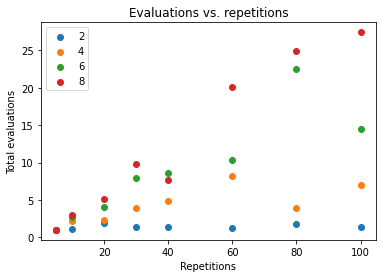

In [ ]:
# reps = [5, 10, 20, 30, 40, 60, 80, 100]
# depths = [2, 4, 6, 8]

# %matplotlib inline

# [plt.scatter(reps, [res_dict[(depth, rep, "eval")] for rep in reps]) for depth in depths]

# plt.legend(depths)
# plt.title("Evaluations vs. repetitions")
# plt.xlabel("Repetitions")
# plt.ylabel("Total evaluations")

Text(0, 0.5, 'Mean time per move')

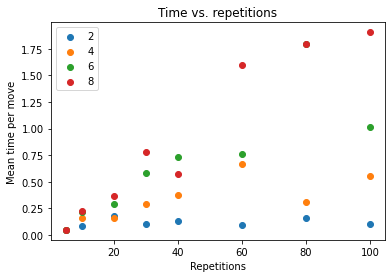

In [ ]:
# %matplotlib inline

# [plt.scatter(reps, [res_dict[(depth, rep, "time")] for rep in reps]) for depth in depths]
# # plt.scatter(reps, times)

# plt.legend(depths)
# plt.title("Time vs. repetitions")
# plt.xlabel("Repetitions")
# plt.ylabel("Mean time per move")

In [ ]:
# import json, codecs

# Zl = [[res_dict[(depth, rep, "time")] for rep in reps] for depth in depths]

# X, Y = np.meshgrid(reps, depths)
# # Z_time = np.stack([
# #     times
# # ])


# Xl = X.tolist() # nested lists with same data, indices
# Yl = Y.tolist() # nested lists with same data, indices
# # Zl = Z_time.tolist() # nested lists with same data, indices

# file_path_X = "data/chartX.json" ## your path variable
# file_path_Y = "data/chartY.json" ## your path variable
# file_path_Z = "data/chartZ.json" ## your path variable

# json.dump(Xl, codecs.open(file_path_X, 'w', encoding='utf-8'), 
#           separators=(',', ':'), 
#           sort_keys=True, 
#           indent=4) ### this saves the array in .json format

# json.dump(Yl, codecs.open(file_path_Y, 'w', encoding='utf-8'), 
#           separators=(',', ':'), 
#           sort_keys=True, 
#           indent=4) ### this saves the array in .json format

# json.dump(Zl, codecs.open(file_path_Z, 'w', encoding='utf-8'), 
#           separators=(',', ':'), 
#           sort_keys=True, 
#           indent=4) ### this saves the array in .json format

# # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# # surf = ax.plot_surface(X, Y, Z_time, linewidth=0, antialiased=False)

# # plt.show()

In [ ]:
path_fixed_model = ""       # create a model that continually learns, and another model that is fixed and does the MCTS
path_updating_model = ""    # every now and then update the second model to match the first one
experience_buffer = []   # the bigger the better, check with some experiments
start_learning_from = int(5e4)

# idea: start learning after 50000 samples are in the queue, and randomly select them to pass them through the network, then REMOVE them from the queue
# IN PARALLEL, keep playing games with the fixed_model to fill up the queue --> if this step is much faster (or the opposite) --> just wait a bit for the slower one, so that the queue always stays
# between ~50k and ~100k

# ideally: infinite while loop that launches in parallel two threads/processes:
# 1) generates self-play samples (planes, (moves, outcome)) that then get COPIED (otherwise parallelism will screw everything up) and added to the queue
# 2) randomly selects batches of 512 samples from the buffer

step_per_update = 0
step_per_checkpoint = 10000
# we do not use the evaluator because the evaluation is too expensive --> at every "step per update" the second model is changed

from multiprocessing import Process, Pool

def parallel_functions(functions, args_list):

    if type(functions) == list:
        assert len(functions) == len(args_list), "Args and functions numbers don't match"
    else:
        functions = [functions]
        args = [args_list]
    
    processes = []

    for f, args in zip(functions, args_list):
        p = Process(target=f, args=args)
        p.start()
        processes.append(p)

    for p in processes:
        p.join()


def play_parallel_games_apply(model, experience_buffer, num_games):
    with Pool() as pool: # play as many games as possible in parallel, and add them to the queue
        futures = [pool.apply_async(complete_game, [model]) for w in num_games]
        for f in futures:
            planes, moves, result = f.get()
            for plane, move in zip(planes, moves):
                experience_buffer.append((plane, (move, result)))


def play_parallel_games_imap(model, experience_buffer, num_games):
    tot_moves = 0
    with Pool() as pool: # play as many games as possible in parallel, and add them to the queue
        futures = pool.imap_unordered(eval, [model]*num_games)
        for f in futures:
            planes, moves, result = f
            tot_moves += (len(planes))
            for plane, move in zip(planes, moves):
                experience_buffer.append((plane, (move, result)))
    
    return tot_moves

def train_loop(steps = 0):
    fixed_model = tf.keras.models.load_model(path_fixed_model)
    updating_model = tf.keras.models.load_model(path_updating_model)

    tot_moves = 0
    tot_games = 0

    while steps < int(1e5):
        q_len = len(experience_buffer) 
        if q_len < 50000:
            num_games = os.cpu_count()
            num_moves = play_parallel_games_apply(fixed_model, experience_buffer, num_games)
            # play_parallel_games_imap(fixed_model, experience_buffer, os.cpu_count())
            tot_games += num_games
            tot_moves += num_moves

        else:
            # choose the samples randomly in the experience_buffer
            sample_idxs = np.random.sample(range(q_len), k=conf.SELF_PLAY_BATCH)
            # create the batch and remove them from the buffer
            train_batch = [experience_buffer.pop(idx) for idx in sample_idxs]
            
            
            mean_length_game = tot_moves/tot_games
            # adaptive number of games --> only a BATCH (512) of moves is removed from the queue
            # while a variable number of moves is added, dependind on the length of a game
            # if q_len is bigger than 60k (due to many long games in previous iterations) only one game is played
            # the smaller q_len is, the bigger the number of games
            # moreover, the mean length of the game is constantly updated
            num_games = min(1, round( (60000-q_len)/mean_length_game ))
            

            # start in parallel a new game and the train step
            output_games, output_learning = parallel_functions(
                functions = [play_parallel_games_apply, train_step],
                args = [
                        (fixed_model, experience_buffer, , updating_model]
            )

        



In [18]:
from multiprocessing import Pool

input = tf.keras.layers.Input(shape=(1))
output = tf.keras.layers.Dense(1)(input)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()

model.compile(
    optimizer = 'adam'
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [36]:
import os
from time import time, sleep

def eval(model):
    # print(time())
    sleep(np.random.random()*3)
    return [model(np.zeros(1)), model(np.ones(1))]

def play_parallel_games_apply(model, experience_buffer, num_games):
    with Pool() as pool: # play as many games as possible in parallel, and add them to the queue
        futures = [pool.apply_async(eval, [model]) for w in range(num_games)]
        for f in futures:
            result = f.get()
            for part in result:
                experience_buffer.append(part)

def play_parallel_games_imap(model, experience_buffer, num_games):
    with Pool() as pool: # play as many games as possible in parallel, and add them to the queue
        futures = pool.imap_unordered(eval, [model]*num_games)
        for f in futures:
            result = f
            for part in result:
                experience_buffer.append(part)

l = []
%timeit play_parallel_games_apply(model, l, 50)
l = []
%timeit play_parallel_games_imap(model, l, 50)

1 loop, best of 5: 47.4 s per loop
1 loop, best of 5: 47.1 s per loop
